Given the historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and the task to predict the department-wise sales for each store.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
sns.set_style("whitegrid")
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [3]:
train=pd.read_csv('D://Walmart sales forecast/train.csv')
test=pd.read_csv('D://Walmart sales forecast/test.csv')
feature=pd.read_csv('D://Walmart sales forecast/features.csv')

In [4]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:
* Store - the store number
* Dept - the department number
* Date - the week
* Weekly_Sales -  sales for the given department in the given store
* IsHoliday - whether the week is a special holiday week


In [5]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


This file is identical to train.csv, except for weekly sales tobe predicted 
aslo the sales for each triplet of store, department, and date in this file.

In [6]:
feature.head().transpose()

,0,1,2,3,4
Store,1,1,1,1,1
Date,2010-02-05,2010-02-12,2010-02-19,2010-02-26,2010-03-05
Temperature,42.31,38.51,39.93,46.63,46.5
Fuel_Price,2.572,2.548,2.514,2.561,2.625
MarkDown1,NaN,NaN,NaN,NaN,NaN
MarkDown2,NaN,NaN,NaN,NaN,NaN
MarkDown3,NaN,NaN,NaN,NaN,NaN
MarkDown4,NaN,NaN,NaN,NaN,NaN
MarkDown5,NaN,NaN,NaN,NaN,NaN
CPI,211.096,211.242,211.289,211.32,211.35


This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:
* Store - the store number
* Date - the week
* Temperature - average temperature in the region
* Fuel_Price - cost of fuel in the region
* MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
* CPI - the consumer price index
* Unemployment - the unemployment rate
* IsHoliday - whether the week is a special holiday week

In [7]:
data=pd.merge(train,feature, on=['Store','Date'], how='inner')# first merged train and feature col
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 15 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday_x     421570 non-null bool
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
IsHoliday_y     421570 non-null bool
dtypes: bool(2), float64(10), int64(2), object(1)
memory usage: 45.8+ MB


In [8]:
data.isnull().mean()*100

Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday_x      0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
IsHoliday_y      0.000000
dtype: float64

MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.

In [9]:
data.fillna(0, inplace=True) # filling NAN with 0's
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False


In [10]:
data['Date'] =  pd.to_datetime(data['Date'])
# converting the 'Date' object type column to datetime
data['Date'].head()

0   2010-02-05
1   2010-02-05
2   2010-02-05
3   2010-02-05
4   2010-02-05
Name: Date, dtype: datetime64[ns]

In [11]:
data['Week_No'] = data['Date'].dt.week
data
#convert 'Date' to a week number.

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Week_No
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,5
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,5
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,5
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,5
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,5
5,1,6,2010-02-05,5749.03,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,5
6,1,7,2010-02-05,21084.08,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,5
7,1,8,2010-02-05,40129.01,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,5
8,1,9,2010-02-05,16930.99,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,5
9,1,10,2010-02-05,30721.50,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,5


In [12]:
data.drop('Date', axis=1,inplace=True)
data.dtypes

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday_x        bool
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday_y        bool
Week_No           int64
dtype: object

# handling bool data 

In [13]:
# find bool variables
categorical = [var for var in data.columns if data[var].dtype=='bool']
print('There are {} categorical variables'.format(len(categorical))) 

There are 2 categorical variables


In [14]:
# let's inspect at the number of labels for the different bool variables
for var in categorical:
    print(var, ' contains ', len(data[var].unique()), ' labels')
print('\nTotal number of rows in the dataset: {}'.format(len(data)))

IsHoliday_x  contains  2  labels
IsHoliday_y  contains  2  labels

Total number of rows in the dataset: 421570


In [15]:
# comparing the IsHoliday_x with IsHoliday_y
data[data['IsHoliday_x'] != data['IsHoliday_y']][['IsHoliday_y', 'IsHoliday_x']].head(5)

# all the values are identical / equal to both the features, so only one can be retianed

,IsHoliday_y,IsHoliday_x


In [16]:
data.drop('IsHoliday_y', axis=1,inplace=True) # as it is same feature droping one

In [17]:
print(data['IsHoliday_x'].unique())


[False  True]


In [18]:
# A simple and intuitive way to convert the feature to 0's and 1's might be
data['IsHoliday_x'] = data['IsHoliday_x'].replace(to_replace = True, value = 1)
data['IsHoliday_x'] = data['IsHoliday_x'].replace(to_replace = False, value = 0)
IsHoliday_x= data['IsHoliday_x'].value_counts()
print(data['IsHoliday_x'].unique())

[0. 1.]


# Data Visualization

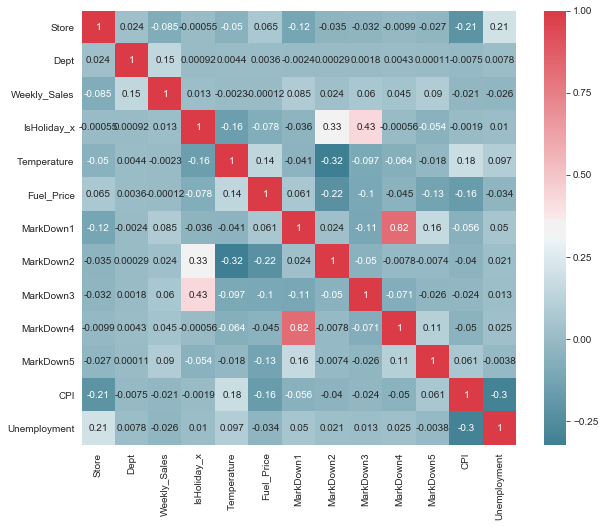

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True),annot=True,
            square=True, ax=ax)

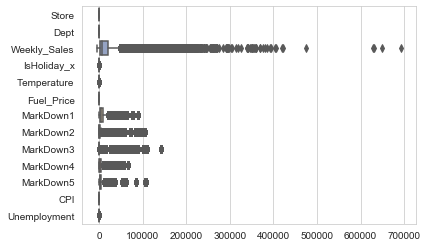

In [62]:
sns.boxplot(data=data, orient="h", palette="Set2")

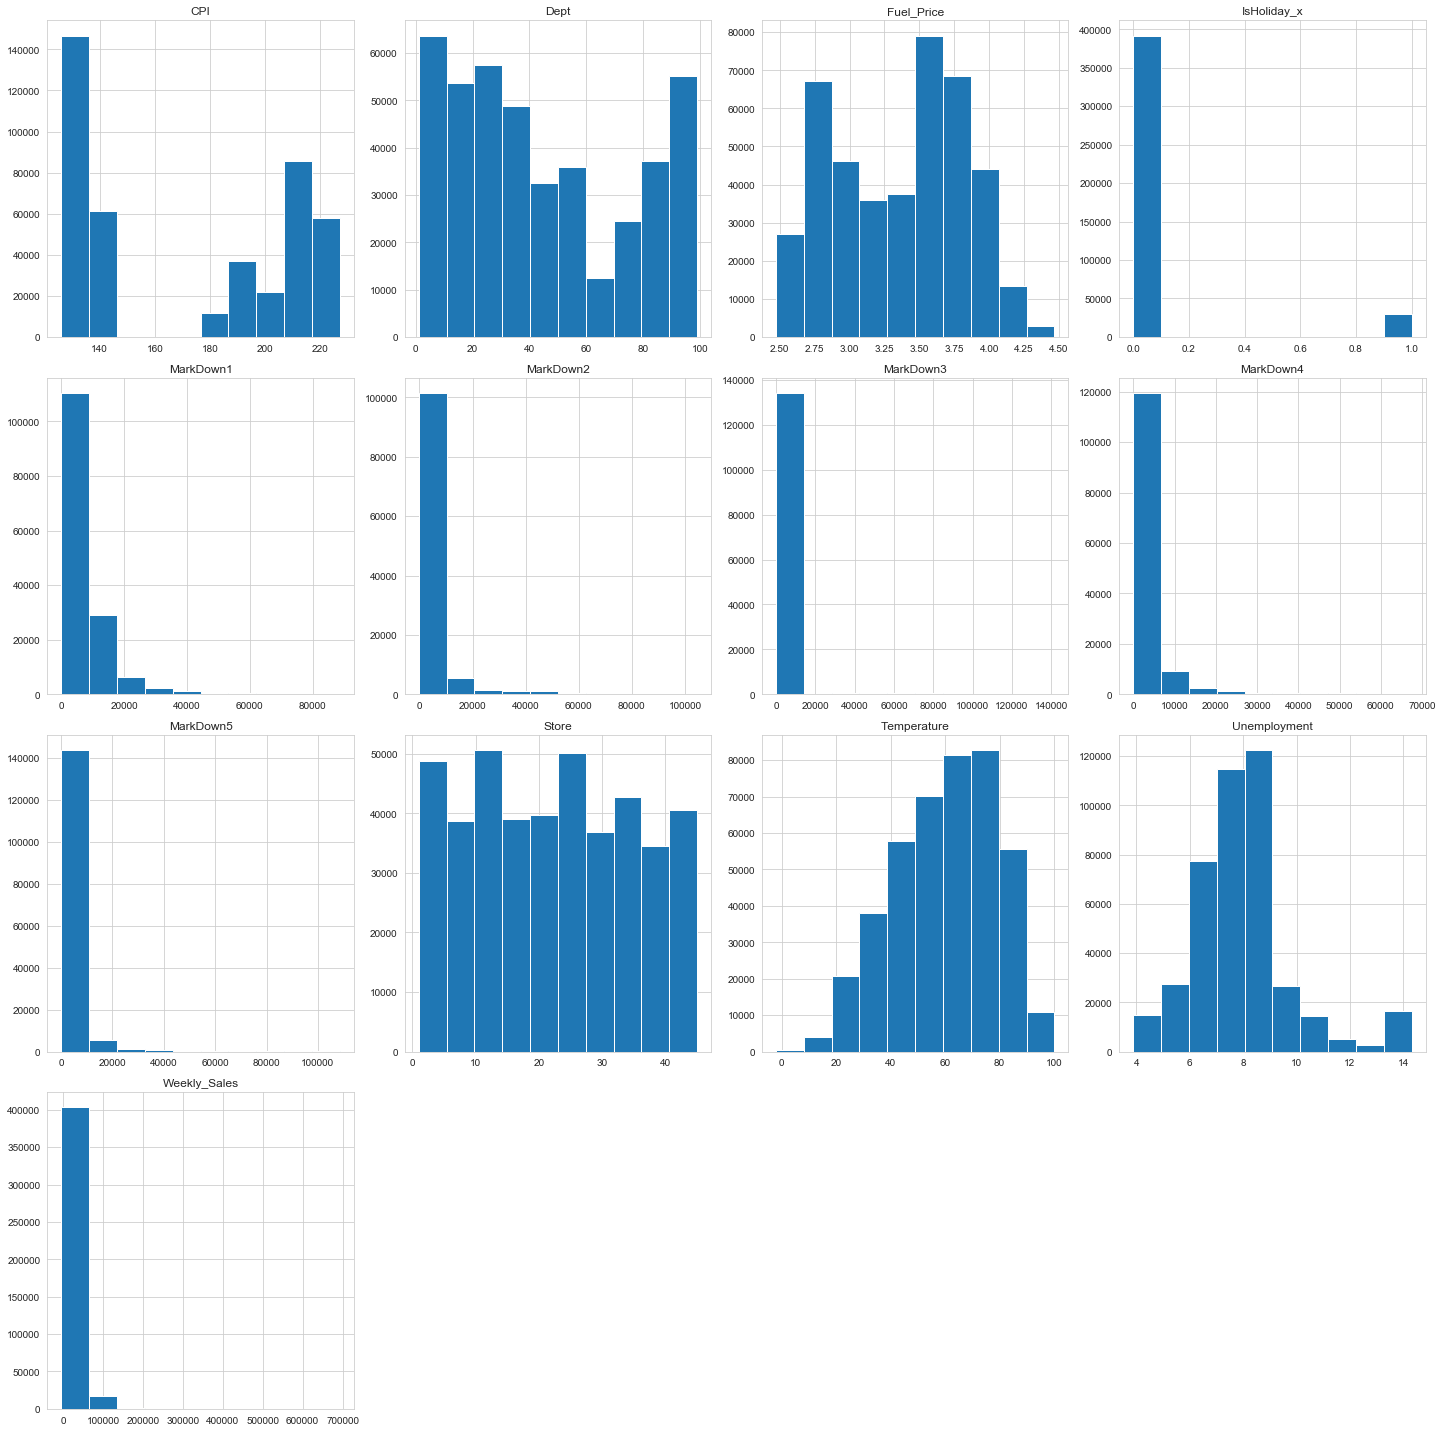

In [63]:
data.hist(figsize=(20, 20))
plt.tight_layout()# tight_layout() will adjust spacing between subplots to minimize the overlaps. let's make good plots
plt.show()

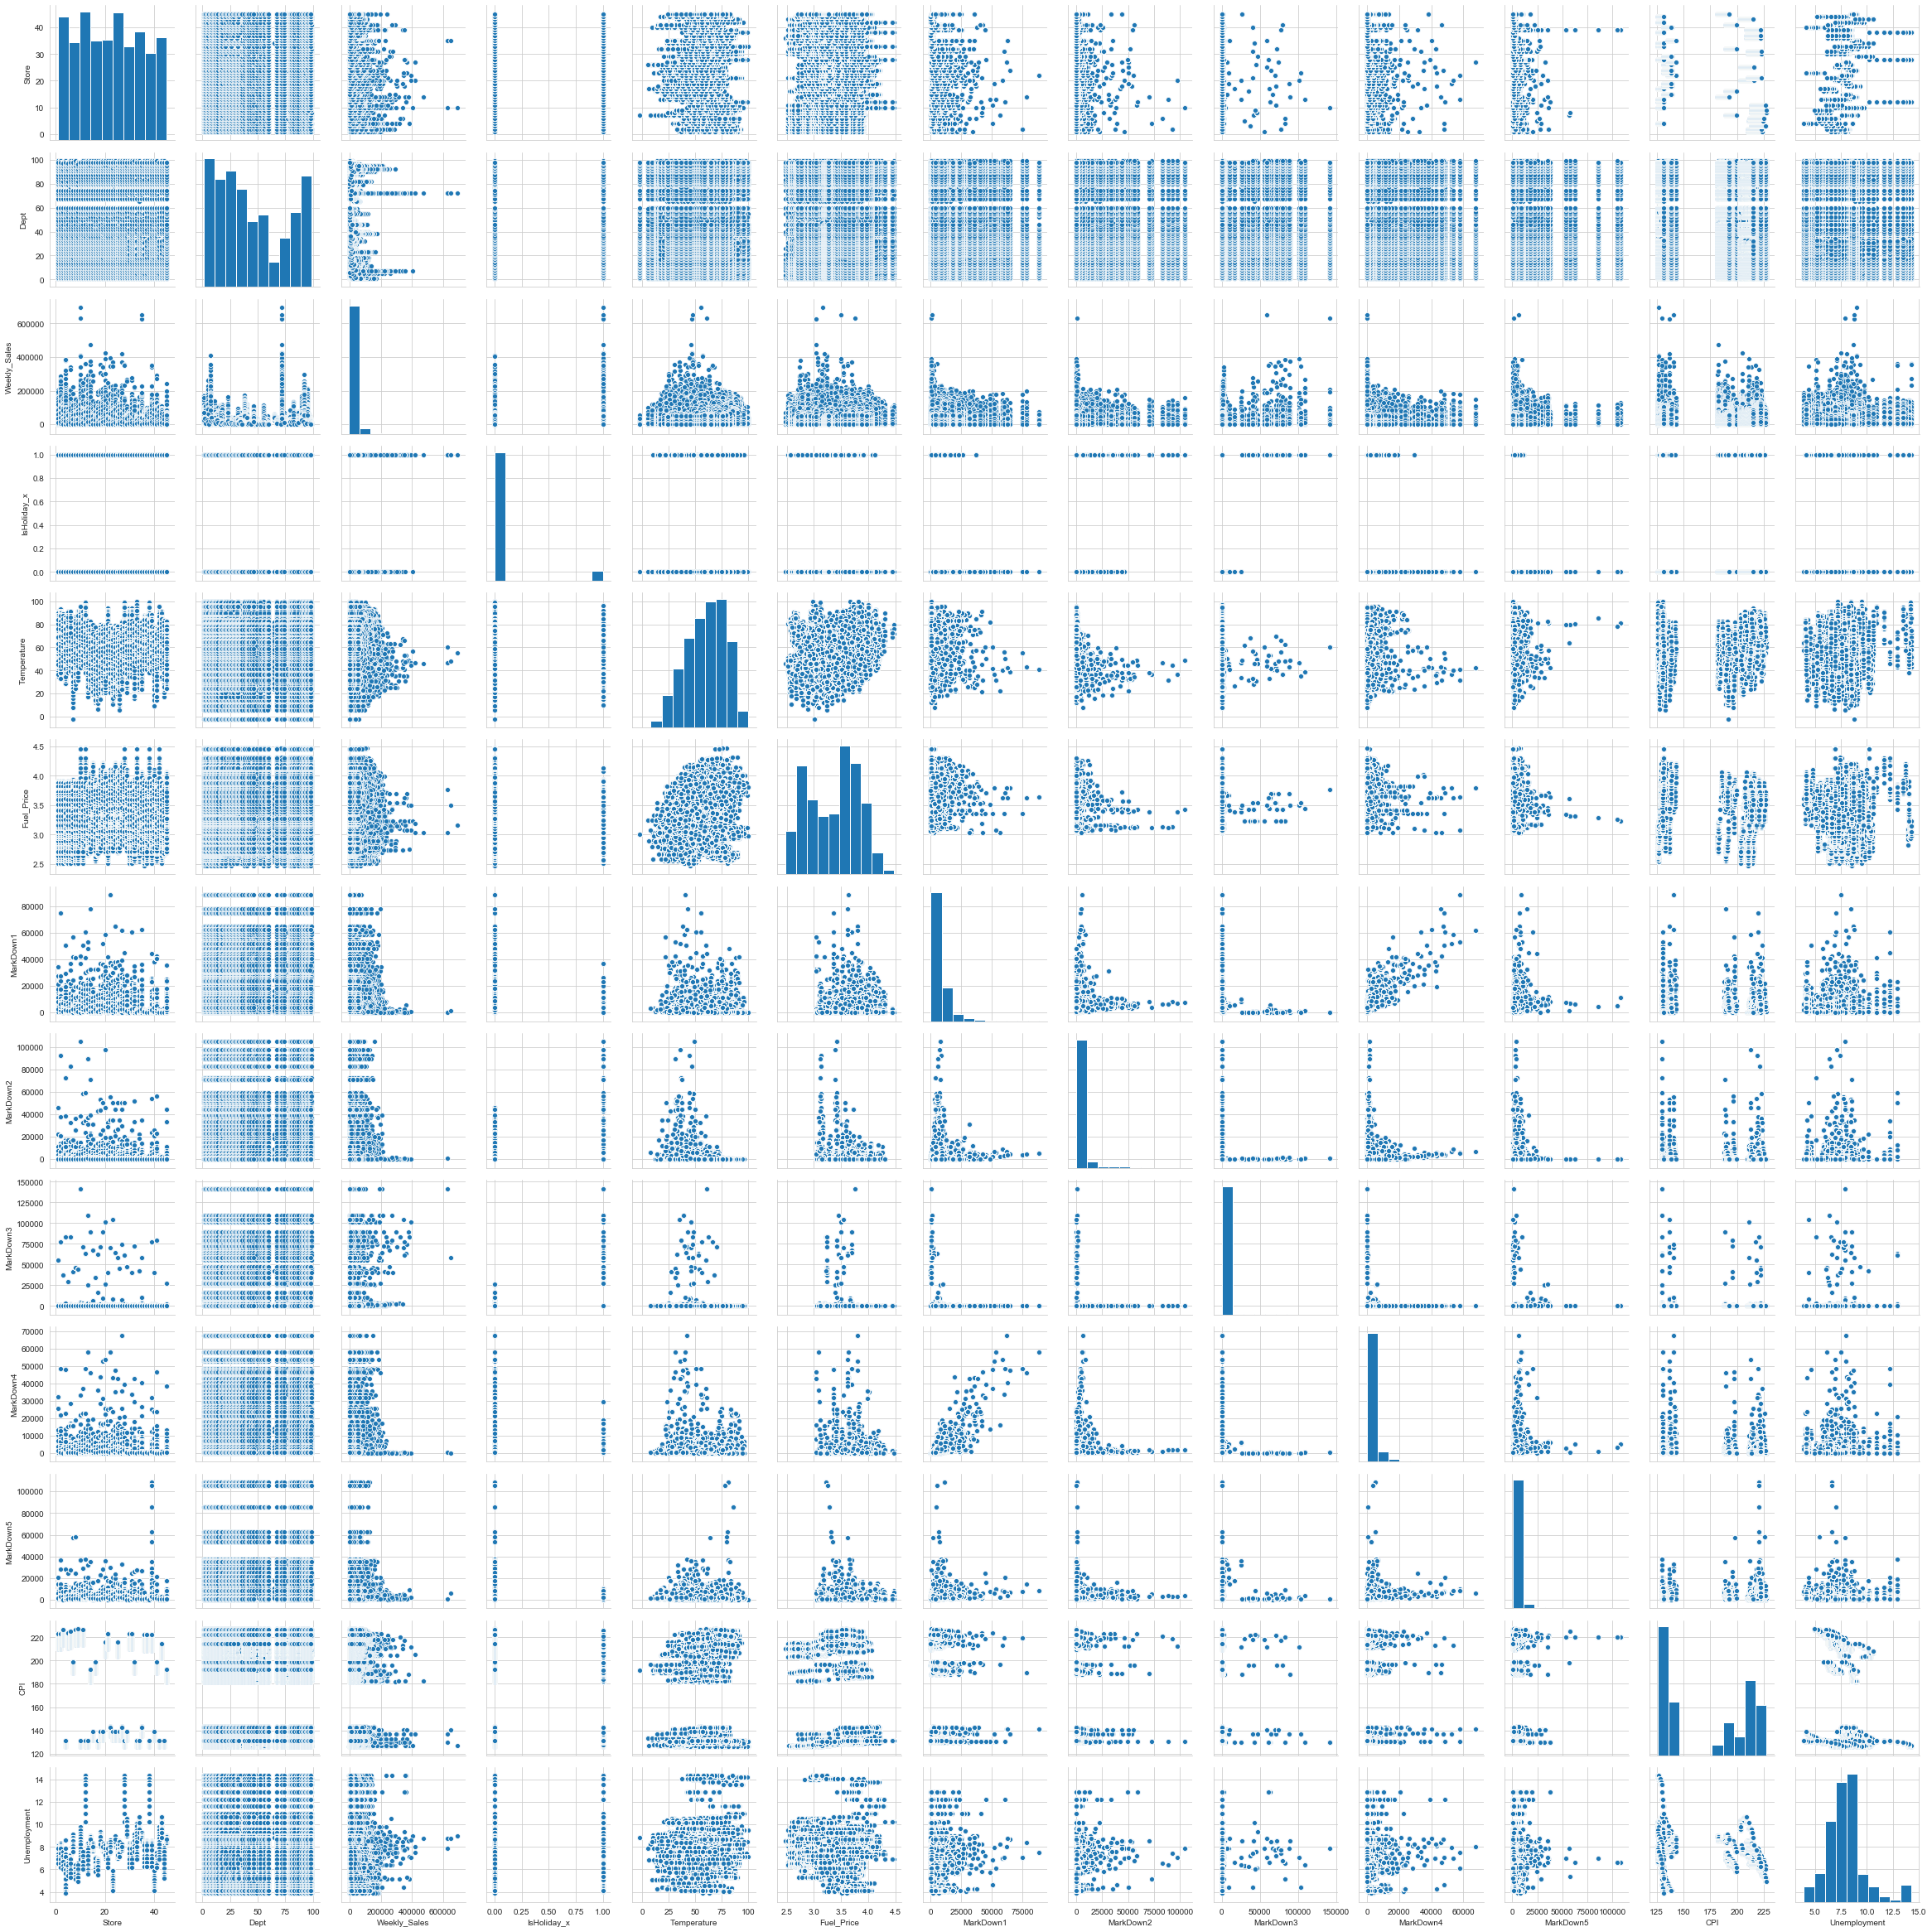

In [64]:
sns.pairplot(data)
plt.tight_layout()
plt.show()

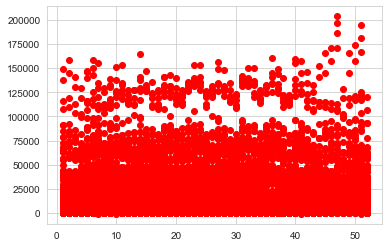

In [79]:
plt.plot(data[(data.Store==1)].Week_No, data[(data.Store==1)].Weekly_Sales, 'ro')
plt.show()  # towards end of year max sales from week 45, 50

### Visualising the relationship plots of dependent and independent variables

Text(0, 0.5, 'Weekly_Sales')

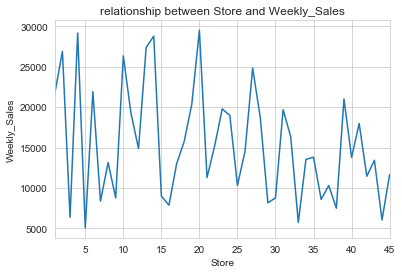

In [81]:
fig = plt.figure()
fig = data.groupby(['Store'])['Weekly_Sales'].mean().plot()
fig.set_title('relationship between Store and Weekly_Sales')
fig.set_ylabel('Weekly_Sales')

Text(0, 0.5, 'Weekly_Sales')

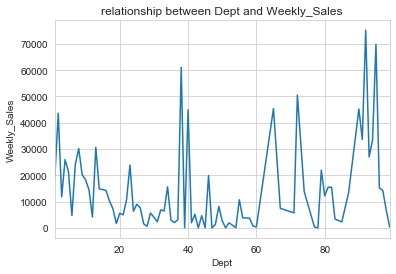

In [82]:
fig = plt.figure()
fig = data.groupby(['Dept'])['Weekly_Sales'].mean().plot()
fig.set_title('relationship between Dept and Weekly_Sales')
fig.set_ylabel('Weekly_Sales')

Text(0, 0.5, 'Weekly_Sales')

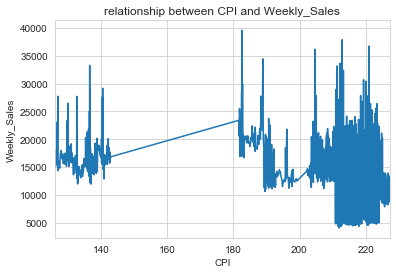

In [83]:
fig = plt.figure()
fig = data.groupby(['CPI'])['Weekly_Sales'].mean().plot()  #CPI - the consumer price index
fig.set_title('relationship between CPI and Weekly_Sales')
fig.set_ylabel('Weekly_Sales')

Text(0, 0.5, 'Weekly_Sales')

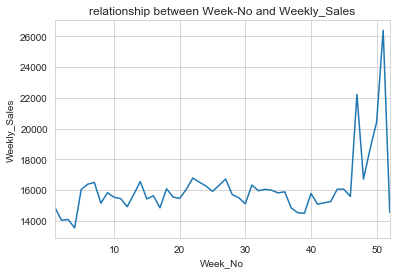

In [84]:
fig = plt.figure()
fig = data.groupby(['Week_No'])['Weekly_Sales'].mean().plot()
fig.set_title('relationship between Week-No and Weekly_Sales')
fig.set_ylabel('Weekly_Sales')

# Feature Importance
#### Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

In [19]:
from sklearn.model_selection import train_test_split
X = data.drop('Weekly_Sales', axis='columns')
y = data.Weekly_Sales
X.head()

,Store,Dept,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week_No
0,1,1,0.0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5
1,1,2,0.0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5
2,1,3,0.0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5
3,1,4,0.0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5
4,1,5,0.0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5


In [90]:
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(X,y)

X.head()

,Store,Dept,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Week_No
0,1,1,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,5
1,1,2,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,5
2,1,3,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,5
3,1,4,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,5
4,1,5,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,5


In [91]:
print(model.feature_importances_)

[0.21741546 0.5838521  0.00359391 0.01593832 0.00903061 0.00630052
 0.00198718 0.0113762  0.00333821 0.00689611 0.06673497 0.03825973
 0.00252282 0.03275387]


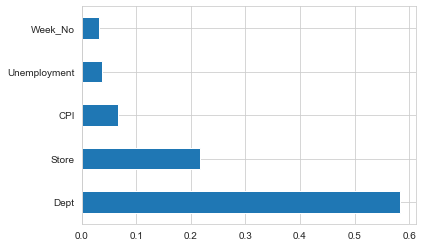

In [92]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

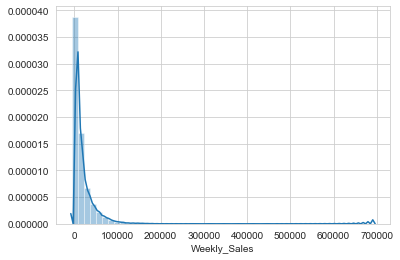

In [93]:
sns.distplot(y)  # cheking the distribution of target.  It is skewed

# selecting the best regression model

In [20]:
from sklearn.model_selection import train_test_split
X=data[['Week_No', 'CPI', 'Unemployment', 'Store','Dept']]# only imp features
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(295099, 5)
(295099,)
(126471, 5)
(126471,)


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor #(random_state=42,silent=True)
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [20]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('RIDGE', Ridge()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('DT', DecisionTreeRegressor()))
#models.append(('SVR', SVR()))
models.append(('ADA', AdaBoostRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('XGB', XGBRegressor(silent=True))) # to silent the WARNING: C:/Jenkins/workspace/xgboost

In [ ]:
from sklearn.model_selection import KFold
results_e2 = []
names_e2 = []

for name, model in models:
    # define how to split off validation data
    kfold = KFold(n_splits=10, random_state='seed')
    
    # train the model
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results_e2.append(cv_results)
    names_e2.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -496648170.655984 (13858956.625312)
LASSO: -496648170.763607 (13858966.965556)
RIDGE: -496648170.651913 (13858956.635313)
EN: -496650729.754185 (13860153.458251)
KNN: -230855074.914557 (9665063.493142)
DT: -26924093.851066 (3900064.744932)


In [ ]:
# Plot results
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
plt.boxplot(results_e2)

fig.suptitle('Algorithm Comparison')
ax.set_xticklabels(names_e2)
plt.show()

# Decision Tree Regressor

In [21]:
from sklearn.tree import DecisionTreeRegressor

In [22]:
dtree=DecisionTreeRegressor(criterion='mse')
dtree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [23]:
print ('the coefficient of determination i.e R^2 for training set : {}'.format(dtree.score(X_train, y_train)))

the coefficient of determination i.e R^2 for training set : 1.0


In [25]:
print ('the coefficient of determination i.e R^2 for test set : {}'.format(dtree.score(X_test,y_test)))

the coefficient of determination i.e R^2 for test set : 0.9464924790626356


In [26]:
dtree_pred = dtree.predict(X_test)

In [28]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
print('MAE:', metrics.mean_absolute_error(y_test, dtree_pred))
print('MSE:', metrics.mean_squared_error(y_test, dtree_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtree_pred)))
r2 = metrics.r2_score(y_test, dtree_pred)
print("R-Squared:", r2)

MAE: 1889.8014328185905
MSE: 27959920.73415112
RMSE: 5287.714131281221
R-Squared: 0.9464924790626356


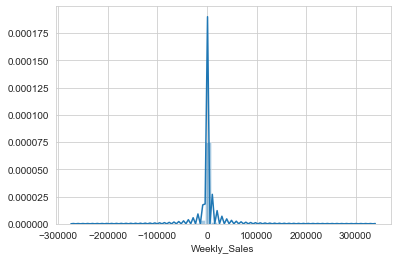

In [29]:
sns.distplot(y_test-dtree_pred)  # difference between y test and y pred is almost normally distributed

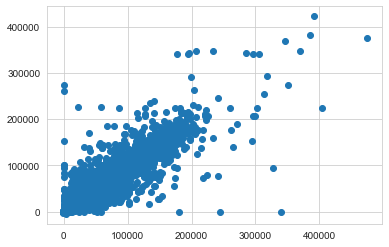

In [30]:
plt.scatter(y_test,dtree_pred)

# Hyper parameter tuning for Decision Tree Regressor with Random Search CV

In [31]:
# hyperparameter tuning using random search cv
from sklearn.model_selection import RandomizedSearchCV  #  random search takes less time compared to grid search cv


In [39]:
# creating a key dictionary pair using the parameters of DecisionTreeRegressor
params={
 "splitter"    : ["best","random"] ,
 "max_depth"        : [ 3, 4, 5 ],
 "min_samples_leaf" : [ 1,2,3 ],
"min_weight_fraction_leaf":[0.1,0.2,0.3],
 "max_features" : ["auto","log2","sqrt",None ],
    "max_leaf_nodes":[None,10,20,30,40]}

In [40]:
random_search=RandomizedSearchCV(dtree,param_distributions=params,scoring='neg_mean_squared_error',n_jobs=-1,cv=10,verbose=3)

In [42]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [45]:
from datetime import datetime
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X,y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished



 Time taken: 0 hours 0 minutes and 15.2 seconds.


In [46]:
random_search.best_params_

{'splitter': 'best',
 'min_weight_fraction_leaf': 0.1,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 30,
 'max_features': None,
 'max_depth': 4}

In [47]:
random_search.best_score_

-432989089.11984175

In [48]:
rand_predictions=random_search.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, rand_predictions))
print('MSE:', metrics.mean_squared_error(y_test, rand_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rand_predictions)))
r2 = metrics.r2_score(y_test, rand_predictions)
print("R-Squared:", r2)

MAE: 13075.617774956369
MSE: 432912047.1346292
RMSE: 20806.53856686953
R-Squared: 0.17152660601787084


In [49]:
#Now compare the actual output values for X_test with the predicted values, execute the following script:
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': rand_predictions.flatten()})
df2 = df1.head(25)
print(df2)

          Actual     Predicted
138040  21580.65  16420.334924
121240   6051.38  11706.229107
180231  20762.42  16420.334924
272846  12842.76  20777.943932
211817  12298.23  11706.229107
274685  37349.39  36148.533291
20030     270.00   5144.445732
47004      10.00  11706.229107
228771   1481.50   5144.445732
45722     576.70  11706.229107
108298    475.20   5144.445732
14395   25405.55  20777.943932
234311   9671.71  20777.943932
248577   3270.36  11706.229107
40036       6.00  16420.334924
366425   1246.37  11706.229107
279185   6855.32  16420.334924
124474    980.15   5144.445732
16524   24201.86  16420.334924
63188    2518.55  11706.229107
99407    8062.36  11706.229107
251743   2335.21  16420.334924
127887   1047.08  11706.229107
301374      0.01  36148.533291
239998   5196.27  11706.229107


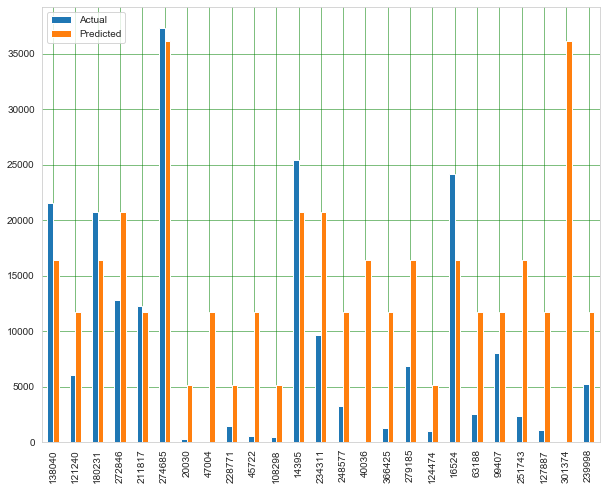

In [50]:
#The comparison plot of Actual and Predicted values
df2.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Not happy with the model, may be it has tobe redone with DL